[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meta-llama/llama-stack/blob/main/docs/getting_started.ipynb)

# Getting Started with Llama 4 in Llama Stack

<img src="https://llama-stack.readthedocs.io/en/latest/_images/llama-stack.png" alt="drawing" width="500"/>

[Llama Stack](https://github.com/meta-llama/llama-stack) defines and standardizes the set of core building blocks needed to bring generative AI applications to market. These building blocks are presented in the form of interoperable APIs with a broad set of Service Providers providing their implementations.

Read more about the project here: https://llama-stack.readthedocs.io/en/latest/index.html

In this guide, we will showcase how you can get started with using Llama 4 in Llama Stack.

**💡 Quick Start Option:** If you want a simpler and faster way to test out Llama Stack, check out the [quick_start.ipynb](quick_start.ipynb) notebook instead. It provides a streamlined experience for getting up and running in just a few steps.


## 1. Getting started with Llama Stack

### 1.1. Create Llama API account

In this showcase, we will use [Llama API](https://llama.developer.meta.com/) as the inference provider. So, you would first get an API key from Llama API if you don't have one already.



> **Note:**  Set the API Key in the Secrets of this notebook



### 1.2. Setup and Running a Llama Stack server

Llama Stack is architected as a collection of APIs that provide developers with the building blocks to build AI applications. 

Llama stack is typically available as a server with an endpoint that you can make calls to. Partners like Together and Fireworks offer their own Llama Stack compatible endpoints.

In this showcase, we will start a Llama Stack server that is running locally.


In [ ]:
import os 
import subprocess
import time

!pip install uv 
!uv pip install requests

if "UV_SYSTEM_PYTHON" in os.environ:
  del os.environ["UV_SYSTEM_PYTHON"]

# this command installs all the dependencies needed for the llama stack server 
!uv run --with llama-stack llama stack build --distro llama_api --image-type venv 

def run_llama_stack_server_background():
    log_file = open("llama_stack_server.log", "w")
    process = subprocess.Popen(
        "uv run --with llama-stack llama stack run llama_api --image-type venv",
        shell=True,
        stdout=log_file,
        stderr=log_file,
        text=True
    )
    
    print(f"Starting Llama Stack server with PID: {process.pid}")
    return process

def wait_for_server_to_start():
    import requests
    from requests.exceptions import ConnectionError
    import time
    
    url = "http://0.0.0.0:8321/v1/health"
    max_retries = 30
    retry_interval = 1
    
    print("Waiting for server to start", end="")
    for _ in range(max_retries):
        try:
            response = requests.get(url)
            if response.status_code == 200:
                print("\nServer is ready!")
                return True
        except ConnectionError:
            print(".", end="", flush=True)
            time.sleep(retry_interval)
            
    print("\nServer failed to start after", max_retries * retry_interval, "seconds")
    return False


# use this helper if needed to kill the server 
def kill_llama_stack_server():
    # Kill any existing llama stack server processes
    os.system("ps aux | grep -v grep | grep llama_stack.core.server.server | awk '{print $2}' | xargs kill -9")


Using Python 3.10.16 environment at: /opt/homebrew/Caskroom/miniconda/base/envs/l4
Audited 1 package in 83ms
Environment '/Users/erichuang/projects/internal-llama-stack/.venv' already exists, re-using it.
Virtual environment /Users/erichuang/projects/internal-llama-stack/.venv is already active
Using Python 3.11.11 environment at: /Users/erichuang/projects/internal-llama-stack/.venv
Audited 1 package in 387ms
Installing pip dependencies
Using Python 3.11.11 environment at: /Users/erichuang/projects/internal-llama-stack/.venv
Resolved 123 packages in 1.13s                                       
⠙ Preparing packages... (0/6)                                                   
⠙ Preparing packages... (0/6)-----     0 B/9.53 KiB                     
⠙ Preparing packages... (0/6)- 9.53 KiB/9.53 KiB                    
shellingham ------------------------------ 9.53 KiB/9.53 KiB
⠙ Preparing packages... (0/6)----     0 B/44.00 KiB                     
shellingham ------------------------------

### 1.3 Starting the Llama Stack Server

In [ ]:
server_process = run_llama_stack_server_background()
assert wait_for_server_to_start()

### 1.4 Install and Configure the Client

Now that we have our Llama Stack server running locally, we need to install the client package to interact with it. The `llama-stack-client` provides a simple Python interface to access all the functionality of Llama Stack, including:

- Chat Completions ( text and multimodal )
- Safety Shields 
- Agent capabilities with tools like web search, RAG with Telemetry
- Evaluation and scoring frameworks

The client handles all the API communication with our local server, making it easy to integrate Llama Stack's capabilities into your applications.

In the next cells, we'll:

1. Install the client package
2. Set up API keys for external services (Together AI and Tavily Search)
3. Initialize the client to connect to our local server


In [3]:
!pip install -U llama-stack-client

Using Python 3.10.16 environment at: /opt/homebrew/Caskroom/miniconda/base/envs/stack
Resolved 31 packages in 284ms                                        
Audited 31 packages in 0.04ms


In [3]:
import os

try:
    from google.colab import userdata
    os.environ['LLAMA_API_KEY'] = userdata.get('LLAMA_API_KEY')
except ImportError:
    print("Not in Google Colab environment")

for key in ['LLAMA_API_KEY']:
    try:
        api_key = os.environ[key]
        if not api_key:
            raise ValueError(f"{key} environment variable is empty")
    except KeyError:
        api_key = input(f"{key} environment variable is not set. Please enter your API key: ")
        os.environ[key] = api_key

from llama_stack_client import LlamaStackClient

client = LlamaStackClient(
    base_url="http://0.0.0.0:8321", 
    provider_data = {
        "llama_api_key": os.environ['LLAMA_API_KEY']
    }
)

Not in Google Colab environment


Now that we have completed the setup and configuration, let's start exploring the capabilities of Llama 4!



## 2. Running Llama 4

### 2.1 Check available models

All the models available are programmatically accessible via the client.

In [13]:
from rich.pretty import pprint

print("Available models:")
for m in client.models.list():
    print(f"- {m.identifier}")


Available models:
- Llama-3.1-8B-Instruct
- meta-llama/Llama-3.1-8B-Instruct
- Llama-3.2-11B-Vision-Instruct
- meta-llama/Llama-3.2-11B-Vision-Instruct
- Llama-3.3-70B-Instruct
- meta-llama/Llama-3.3-70B-Instruct
- Llama-4-Maverick-17B-128E-Instruct-FP8
- meta-llama/Llama-4-Maverick-17B-128E-Instruct
- all-MiniLM-L6-v2


### 2.2 Run a simple chat completion with one of the models

We will test the client by doing a simple chat completion.

In [14]:
# TODO: update this with a vision model
model_id = "meta-llama/Llama-4-Maverick-17B-128E-Instruct"

response = client.inference.chat_completion(
    model_id=model_id,
    messages=[
        {"role": "system", "content": "You are a friendly assistant."},
        {"role": "user", "content": "Write a two-sentence poem about llama."},
    ],
)

print(response.completion_message.content)


Here is a two-sentence poem about a llama:

With soft fur and gentle eyes, the llama roams with gentle surprise, a peaceful presence in the Andean skies. Its calm demeanor and soft humming song bring serenity to all who belong.


### 2.3 Running multimodal inference

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  275k  100  275k    0     0   847k      0 --:--:-- --:--:-- --:--:--  845k--:--:-- --:--:--     0


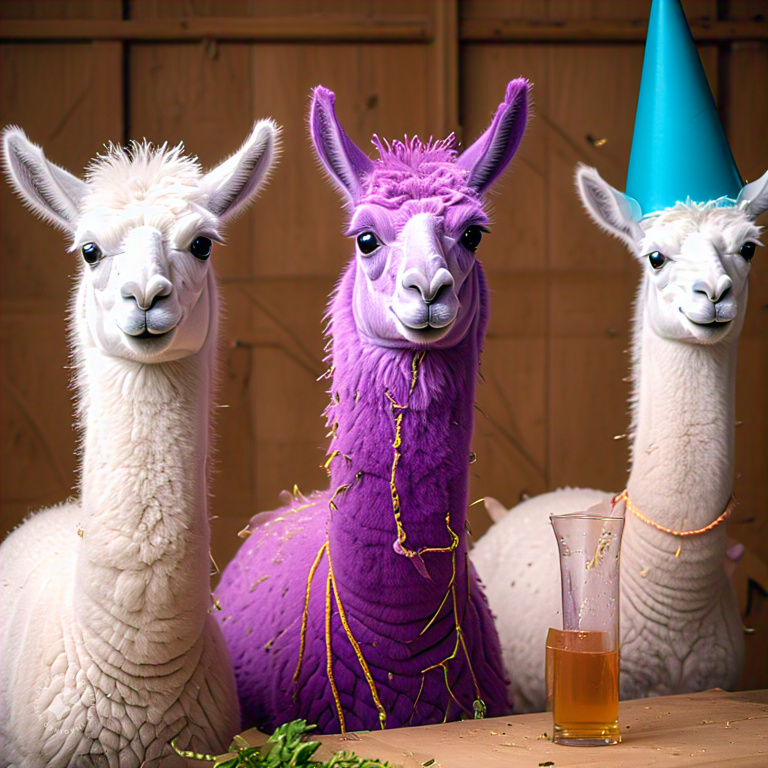

In [15]:
!curl -O https://raw.githubusercontent.com/meta-llama/llama-models/refs/heads/main/Llama_Repo.jpeg

from IPython.display import Image
Image("Llama_Repo.jpeg", width=256, height=256)

In [16]:
import base64
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        base64_string = base64.b64encode(image_file.read()).decode("utf-8")
        base64_url = f"data:image/png;base64,{base64_string}"
        return base64_url

In [18]:
response = client.inference.chat_completion(
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": {
                        "url": {
                            "uri": encode_image("Llama_Repo.jpeg")
                        }
                    }
                },
                {
                    "type": "text",
                    "text": "How many different colors are those llamas? What are those colors?",
                }
            ]
        }
    ],
    model_id=model_id,
    stream=False,
)

print(response.completion_message.content)

The image features three llamas, each with a distinct color. The llama on the left is white, the middle one is purple, and the one on the right is also white but wears a blue party hat.

To determine the number of different colors present, we can count the unique hues:

1. White (two llamas)
2. Purple (one llama)
3. Blue (party hat)

Therefore, there are 3 different colors visible in the image: white, purple, and blue.


### 2.4 Have a conversation

Maintaining a conversation history allows the model to retain context from previous interactions. Use a list to accumulate messages, enabling continuity throughout the chat session.

In [19]:
from termcolor import cprint

questions = [
    "Who was the most famous PM of England during world war 2 ?",
    "What was his most famous quote ?"
]


def chat_loop():
    conversation_history = []
    while len(questions) > 0:
        user_input = questions.pop(0)
        if user_input.lower() in ["exit", "quit", "bye"]:
            cprint("Ending conversation. Goodbye!", "yellow")
            break

        user_message = {"role": "user", "content": user_input}
        conversation_history.append(user_message)

        response = client.inference.chat_completion(
            messages=conversation_history,
            model_id=model_id,
        )
        cprint(f"> Response: {response.completion_message.content}", "cyan")

        assistant_message = {
            "role": "assistant",  # was user
            "content": response.completion_message.content,
            "stop_reason": response.completion_message.stop_reason,
        }
        conversation_history.append(assistant_message)


chat_loop()


> Response: The most famous Prime Minister of England during World War 2 was Winston Churchill. He served as the Prime Minister of the United Kingdom from 1940 to 1945, and again from 1951 to 1955. Churchill is widely regarded as one of the greatest wartime leaders in history, known for his leadership, oratory skills, and unwavering resolve during the war.

Churchill played a crucial role in rallying the British people during the war, and his speeches, such as the "We shall fight on the beaches" and "Their finest hour" speeches, are still remembered and celebrated today. He worked closely with other Allied leaders, including US President Franklin D. Roosevelt and Soviet leader Joseph Stalin, to coordinate the war effort and ultimately secure the defeat of Nazi Germany.

Churchill's leadership and legacy have endured long after the war, and he remains one of the most iconic and influential figures in British history.
> Response: Winston Churchill was known for his many memorable quotes,

Here is an example for you to try a conversation yourself.
Remember to type `quit` or `exit` after you are done chatting.

In [35]:
# NBVAL_SKIP
from termcolor import cprint

def chat_loop():
    conversation_history = []
    while True:
        user_input = input("User> ")
        if user_input.lower() in ["exit", "quit", "bye"]:
            cprint("Ending conversation. Goodbye!", "yellow")
            break

        user_message = {"role": "user", "content": user_input}
        conversation_history.append(user_message)

        response = client.inference.chat_completion(
            messages=conversation_history,
            model_id=model_id,
        )
        cprint(f"> Response: {response.completion_message.content}", "cyan")

        assistant_message = {
            "role": "assistant",  # was user
            "content": response.completion_message.content,
            "stop_reason": response.completion_message.stop_reason,
        }
        conversation_history.append(assistant_message)


chat_loop()


> Response: Hello! How are you today? Is there something I can help you with or would you like to chat?
Ending conversation. Goodbye!
